The yardage gained by a returner after kickoff and punt is strongly affected by defensive and offensive formations. These formations determine what kind of interactions between players occurs , which in turn affects the returner's route. We can observe the return yardage and who blocks the returner; however, how other players influence on the return yard is unclear. 

To evaluate the contributions of all players, we adopt **Cox proportional hazard model** to express the distribution of the return yardage. We decompose the **hazard**, which is the rate of the returner being stopped, to the sum of the contributions of each player. To consider the interaction between players, we use a gated graph neural network that utilizes the Delaunay triangulation.

This notebook consists of the following topics.

* Explanation of how to use hazard model for return yardage after kickoff and punt
* Definition of Cox proportional hazard model with gated graph neural networks
* Application 1: Model training 
* Application 2: Ranking of teams 
* Application 3: How to find better offensive formation
* Appendix: Comparison with hazard model without graph

# Hazard modeling of return yardage

Hazard modeling aims to model the duration of time until some events happen given covariate information. For example, to know the efficacy of the medicine, we investigate how the medicine decreases the death rate.
In hazard modeling, we estimate the hazard function instead of the probability density function. The hazard function is the instantaneous rate of the event occurrence. 

We assume that the return yardage is a time duration of events. Let $y$ be return yardage. The obtained yardage takes a discrete value, so we here estimate the discrete hazard function

$$
\begin{aligned}
h(y) = \mathrm{Pr}(y \leq Y < y + 1 \mid Y \geq y),
\end{aligned}
$$

This function explains the probability of a returner being stopped at $y$.

After a returner receives a ball, the defensive players try to stop this returner as soon as possible, whereas the offensive players prevent the defensive players from tackling the returner. In terms of the hazard function, defensive players try to increase $h(y)$, and offensive players decrease $h(y)$. 

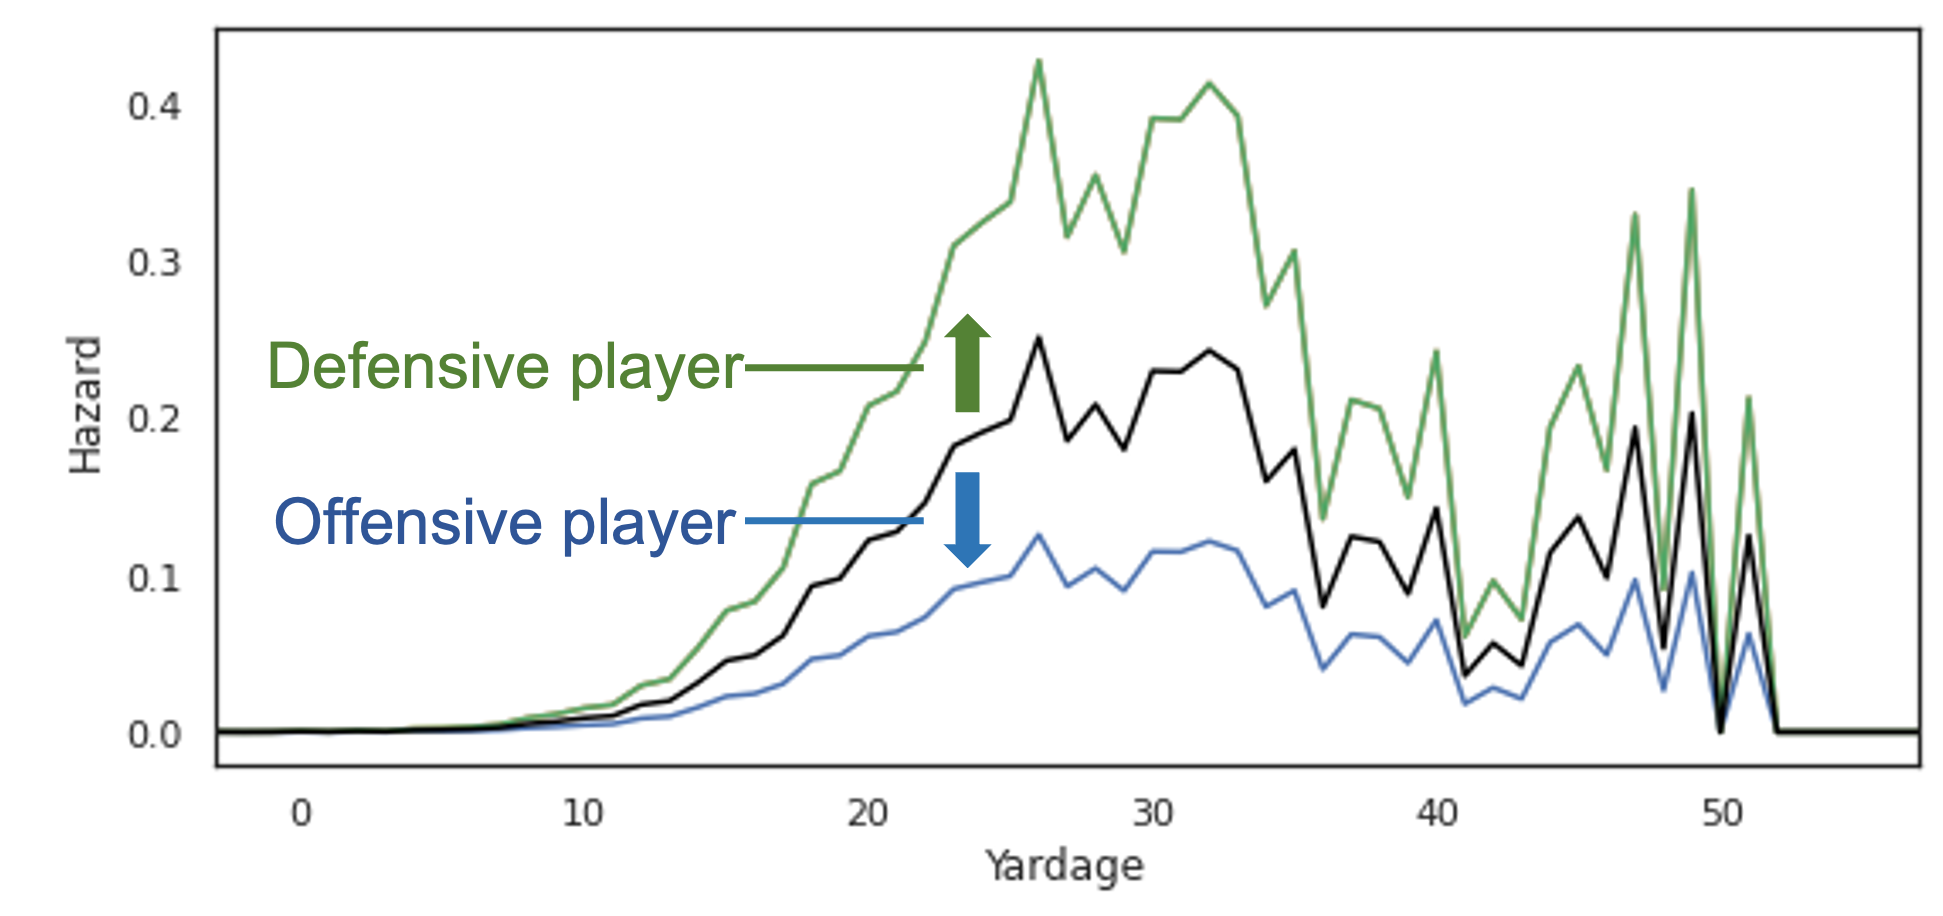

Our aim is to estimate how each player affects this hazard. It is not sufficient to evaluate players' contributions by simple stats like obtained yards, touchdowns, and tackles. When a returner gains long yards after a kickoff, how other offensive players contribute to this gain is unclear. Using hazard values enables us to compare players' contributions between different positions. 

# Cox proportional hazard model with gated graph neural networks

We adopt **Cox proportional model** to express the hazard function. Cox proportional model divides the hazard function into two parts as

$$
\begin{aligned}
    h(y) = h_0(y) \cdot \exp(\phi(x)), \, \text{$x$ : covariates.}
\end{aligned}
$$


The former part indicates how the hazard function depends on the yardage and the latter part indicates how it depends on the covariate information. The Cox model estimates the former part in a semiparametric manner without any model specification.

We define $\phi(x)$ as the summation of the contributions of players.
$$
\begin{aligned}
    \phi(x) =  \phi_\mathrm{R}(x_\mathrm{R} \mid x) + \sum_{i=1}^{10} \phi_\mathrm{O}(x^{(i)}_\mathrm{O} \mid x) + \sum_{j=1}^{11} \phi_\mathrm{D}(x^{(j)}_\mathrm{D} \mid x).
\end{aligned}
$$
Here, $x_\mathrm{R}, \{x^{(i)}_\mathrm{O}\}_{i=1, \cdots, 10} \,\, ,  \{x^{(j)}_\mathrm{D}\}_{j=1, \cdots, 11} \, \, $ are player's information for a returner, offensive players and defensive players. Specifically, we use players' locations and velocities when the returner recieves the ball as $x$. $\phi_\mathrm{R}(\cdot), \phi_\mathrm{O}(\cdot), \phi_\mathrm{D}(\cdot)$ are estimand functions that transform players' information into hazards.

Each player's contribution to the hazard is also affected by nearby players. We express these interactions as graph expressions. 
First, we calculate the Delaunay diagram from players' locations and construct a graph that indicates the pairs of nearby players.
Under this graph, we adopt **Gated Graph Neural Network** for expressing $\phi_\mathrm{R}(\cdot), \phi_\mathrm{O}(\cdot), \phi_\mathrm{D}(\cdot)$. 

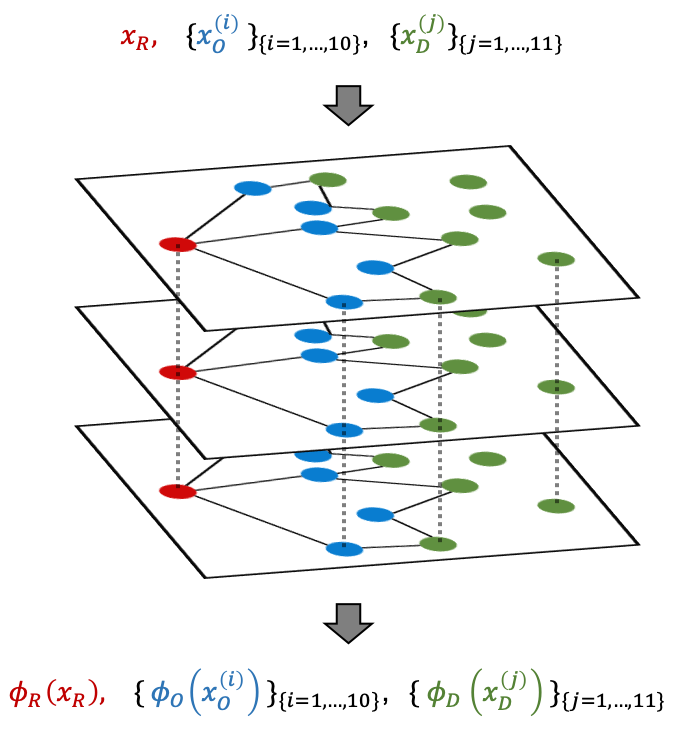

# Application 1: Model training 

In this notebook, we focus on **kickoff** plays and construct the hazard model for kickoff returns. We first extract players' locations and velocities when the returner receives the ball, and then split the data into three partitions; the first partition for model training, the second one for model validation, and the last one for model evaluation. 

We omit the details of our model, but this notebook contains the full implementation of it. For details of gated graph neural networks, check the following paper.
* Li et al., Gated Graph Sequence Neural Networks, ICLR, 2020.

In [ ]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import Delaunay
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set()
sns.set_style('white')

In [ ]:
def find_adjacent(loc):

    delau = Delaunay(loc)
    adj = np.zeros((22, 22))
    ind = np.arange(22)

    for i in range(delau.simplices.shape[0]):
        for j in delau.simplices[i]:
            adj[ind[j], ind[delau.simplices[i]]] = 1

    adj *= 1 - np.eye(22)
    
    return adj


def extract_feature(game, play, play_detail):

    homeTeam, awayTeam = game.homeTeamAbbr.values[0], game.visitorTeamAbbr.values[0]
    possessionTeam = play.possessionTeam.values[0]

    vel = pd.concat([np.cos((- play_detail.dir.values + 90) / 360 * 2 * np.pi) * play_detail['s'], np.sin((- play_detail.dir.values + 90) / 360 * 2 * np.pi) * play_detail['s']], axis=1)
    vel.columns = ['vel_x', 'vel_y']
    play_detail = pd.concat([play_detail, vel], axis=1)

    play_detail_football = play_detail.query('team == "football"')

    if homeTeam == possessionTeam:
        play_detail_offense, play_detail_defense = play_detail.query('team == "away"'), play_detail.query('team == "home"')
        defense_team, offense_team = homeTeam, awayTeam
    else:
        play_detail_offense, play_detail_defense = play_detail.query('team == "home"'), play_detail.query('team == "away"')
        offense_team, defense_team = homeTeam, awayTeam

    returnerId = play.returnerId.values[0].split(';')[0]
    play_detail_returner = play_detail_offense.query('nflId == %s' % returnerId)
    returnerLine = play_detail_returner.x.values[0]

    direction = 2 * np.float('left' == play_detail.playDirection.values[0]) - 1

    position_returner = play_detail_returner.position.values
    position_offense = play_detail_offense.position.values
    position_defense = play_detail_defense.position.values

    name_returner = play_detail_returner.displayName.values
    name_offense = play_detail_offense.displayName.values
    name_defense = play_detail_defense.displayName.values

    is_not_returner = np.logical_not(np.any(name_offense == name_returner[:, np.newaxis], 0))

    position = np.hstack([position_returner, position_offense[is_not_returner], position_defense])
    name = np.hstack([name_returner, name_offense[is_not_returner], name_defense])

    loc_returner = (play_detail_returner[['x', 'y']].values - np.array([returnerLine, 53.3 / 2])) * direction
    loc_offense = (play_detail_offense[['x', 'y']].values - np.array([returnerLine, 53.3 / 2])) * direction
    loc_defense = (play_detail_defense[['x', 'y']].values - np.array([returnerLine, 53.3 / 2])) * direction

    vel_returner = play_detail_returner[['vel_x', 'vel_y']].values * direction
    vel_offense = play_detail_offense[['vel_x', 'vel_y']].values * direction
    vel_defense = play_detail_defense[['vel_x', 'vel_y']].values * direction
    
    loc = np.vstack([loc_returner, loc_offense[is_not_returner], loc_defense])
    vel = np.vstack([vel_returner, vel_offense[is_not_returner], vel_defense])
    
    x = np.hstack([loc, vel])

    adj = find_adjacent(loc)

    y = np.minimum(play.kickReturnYardage.values[0], np.floor(loc[:, 0].max()))
    c = y != np.floor(loc[:, 0].max())
    
    return x, adj, y, c, name, position, offense_team, defense_team

In [ ]:
dirname = '/kaggle/input/nfl-big-data-bowl-2022'

games = pd.read_csv(os.path.join(dirname, 'games.csv'))
plays = pd.read_csv(os.path.join(dirname, 'plays.csv'))
players = pd.read_csv(os.path.join(dirname, 'players.csv'))

punt = plays.query('kickReturnYardage == kickReturnYardage and specialTeamsPlayType == "Punt" and not playDescription.str.contains("fair|try|PENALTY|Penalty|MUFFS|onside")', engine='python')
kick = plays.query('kickReturnYardage == kickReturnYardage and specialTeamsPlayType == "Kickoff" and not playDescription.str.contains("fair|try|PENALTY|Penalty|MUFFS|onside")', engine='python')
plays = kick

tracking2018 = pd.read_csv(os.path.join(dirname, 'tracking2018.csv')).query('event == "kick_received" or event == "punt_received"')
tracking2019 = pd.read_csv(os.path.join(dirname, 'tracking2019.csv')).query('event == "kick_received" or event == "punt_received"')
tracking2020 = pd.read_csv(os.path.join(dirname, 'tracking2020.csv')).query('event == "kick_received" or event == "punt_received"')
tracking = pd.concat([tracking2018, tracking2019, tracking2020], axis=0)

In [ ]:
xs, adjs, ys, cs = [], [], [], []
names, positions, offense_teams, defense_teams = [], [], [], []

gameIds = plays.gameId.values
playIds = plays.playId.values

ind = 0
inds = []

for gameId, playId in zip(gameIds, playIds):

    game = games.query('gameId == %s' % gameId)
    play = plays.query('gameId == %s and playId == %s' % (gameId, playId))
    play_detail = tracking.query('gameId == %s and playId == %s' % (gameId, playId))

    try:
        x, adj, y, c, name, position, offense_team, defense_team = extract_feature(game, play, play_detail)

        xs.append(x)
        adjs.append(adj)
        ys.append(y)
        cs.append(c)

        names.append(name)
        positions.append(position)
        offense_teams.append(offense_team)
        defense_teams.append(defense_team)

        inds.append(ind)
        ind += 1

    except:
        pass

    
xs, adjs, ys, cs = np.stack(xs), np.stack(adjs), np.hstack(ys), np.array(cs).astype(np.int)
names, positions, offense_teams, defense_teams = np.vstack(names),  np.vstack(positions), np.hstack(offense_teams), np.hstack(defense_teams)
inds = np.stack(inds)

(inds, inds_eval, xs, xs_eval, adjs, adjs_eval, ys, ys_eval, cs, cs_eval,
 names, names_eval, positions, positions_eval, offense_teams, offense_teams_eval, defense_teams, defense_teams_eval) = train_test_split(inds, xs, adjs, ys, cs, names, positions, offense_teams, defense_teams, test_size=0.2, random_state=0)

(inds_test, inds_eval, xs_test, xs_eval, adjs_test, adjs_eval, ys_test, ys_eval, cs_test, cs_eval,
 names_test, names_eval, positions_test, positions_eval, offense_teams_test, offense_teams_eval, defense_teams_test, defense_teams_eval) = train_test_split(inds_eval, xs_eval, adjs_eval, ys_eval, cs_eval, names_eval, positions_eval, offense_teams_eval, defense_teams_eval, test_size=0.5, random_state=0)

In [ ]:
X_orig, A_orig = tf.constant(xs, dtype=tf.float32), tf.constant(adjs, dtype=tf.float32)
X_eval, A_eval = tf.constant(xs_eval, dtype=tf.float32), tf.constant(adjs_eval, dtype=tf.float32)
X_test, A_test = tf.constant(xs_test, dtype=tf.float32), tf.constant(adjs_test, dtype=tf.float32)

xs, adjs, ys, cs = np.vstack([xs, xs * np.array([1, -1, 1, -1])]), np.vstack([adjs, adjs]), np.hstack([ys, ys]), np.hstack([cs, cs])
xs, adjs, ys, cs = xs[np.argsort(ys)], adjs[np.argsort(ys)], ys[np.argsort(ys)], cs[np.argsort(ys)]
X, A = tf.constant(xs, dtype=tf.float32), tf.constant(adjs, dtype=tf.float32)


n = xs.shape[0]
ys_unique, ys_index, ys_inverse, ys_count = np.unique(ys, return_index=True, return_inverse=True, return_counts=True)

ys_mask_index = np.arange(ys_unique[0], ys_unique[-1] + 1)
ys_mask = tf.constant(ys_mask_index[:, np.newaxis] == ys_unique, dtype=tf.float32)

cs_count = []
for j in ys_unique:
    cs_count.append(cs[ys == j].sum())

cs_count = np.array(cs_count)

cs_mask = np.zeros((n, ys_unique.shape[0]))
for j, index, count in zip(range(ys_unique.shape[0]), ys_index, ys_count):
    cs_mask[index:index+count, j] = 1.
cs_mask = tf.constant(cs_mask, dtype=tf.float32)

mask = tf.constant(ys_index <= np.arange(n)[:, np.newaxis], dtype=tf.float32)
inf_array = - tf.ones_like(mask, dtype=tf.float32) * np.inf

df_true = 0.5 * (tf.sign(ys_mask_index - ys_eval[:, tf.newaxis]) + 1)

In [ ]:
class GGNN(tf.keras.Model):


    def __init__(self):

        super(GGNN, self).__init__()

        self.gru_L = 10

        self.denseGRU_R = tf.keras.Sequential([tf.keras.layers.Dense(n_layerGRU, activation=tf.nn.tanh), tf.keras.layers.Dropout(dropout_rate),
                                               tf.keras.layers.Dense(n_layerGRU, activation=tf.nn.tanh), tf.keras.layers.Dropout(dropout_rate),
                                               tf.keras.layers.Dense(n_layerGRU, activation=tf.nn.tanh)])
        self.denseGRU_O = tf.keras.Sequential([tf.keras.layers.Dense(n_layerGRU, activation=tf.nn.tanh), tf.keras.layers.Dropout(dropout_rate),
                                               tf.keras.layers.Dense(n_layerGRU, activation=tf.nn.tanh), tf.keras.layers.Dropout(dropout_rate),
                                               tf.keras.layers.Dense(n_layerGRU, activation=tf.nn.tanh)])
        self.denseGRU_D = tf.keras.Sequential([tf.keras.layers.Dense(n_layerGRU, activation=tf.nn.tanh), tf.keras.layers.Dropout(dropout_rate),
                                               tf.keras.layers.Dense(n_layerGRU, activation=tf.nn.tanh), tf.keras.layers.Dropout(dropout_rate),
                                               tf.keras.layers.Dense(n_layerGRU, activation=tf.nn.tanh)])
        
        self.update_R, self.update_O, self.update_D = tf.keras.layers.Dense(n_layerGRU, activation=tf.nn.sigmoid), tf.keras.layers.Dense(n_layerGRU, activation=tf.nn.sigmoid), tf.keras.layers.Dense(n_layerGRU, activation=tf.nn.sigmoid)
        self.reset_R, self.reset_O, self.reset_D = tf.keras.layers.Dense(n_layerGRU, activation=tf.nn.sigmoid), tf.keras.layers.Dense(n_layerGRU, activation=tf.nn.sigmoid), tf.keras.layers.Dense(n_layerGRU, activation=tf.nn.sigmoid)
        self.modify_R, self.modify_O, self.modify_D = tf.keras.layers.Dense(n_layerGRU, activation=tf.nn.tanh), tf.keras.layers.Dense(n_layerGRU, activation=tf.nn.tanh), tf.keras.layers.Dense(n_layerGRU, activation=tf.nn.tanh)
        
        self.dropoutGRU_R, self.dropoutGRU_O, self.dropoutGRU_D = tf.keras.layers.Dropout(dropout_rate), tf.keras.layers.Dropout(dropout_rate), tf.keras.layers.Dropout(dropout_rate)
        self.dropoutGRU_neighbor_R, self.dropoutGRU_neighbor_O, self.dropoutGRU_neighbor_D = tf.keras.layers.Dropout(dropout_rate), tf.keras.layers.Dropout(dropout_rate), tf.keras.layers.Dropout(dropout_rate)

        self.dense_R, self.dense_O, self.dense_D = tf.keras.layers.Dense(1), tf.keras.layers.Dense(1), tf.keras.layers.Dense(1)
        self.mask_R, self.mask_O, self.mask_D = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid), tf.keras.layers.Dense(1, activation=tf.nn.sigmoid), tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
    
    def call(self, X, A, is_training=False):

        X_R = tf.slice(X, [0, 0, 0], [-1, 1, -1])
        X_O = tf.concat([tf.tile(X_R, (1, 10, 1)), tf.slice(X, [0, 1, 0], [-1, 10, -1])], axis=2)
        X_D = tf.concat([tf.tile(X_R, (1, 11, 1)), tf.slice(X, [0, 11, 0], [-1, 11, -1])], axis=2)

        layerGRU_R, layerGRU_O, layerGRU_D = self.denseGRU_R(X_R, is_training), self.denseGRU_O(X_O, is_training), self.denseGRU_D(X_D, is_training)
       
        maskGRU_update_R, maskGRU_update_O, maskGRU_update_D = self.dropoutGRU_R(tf.ones_like(layerGRU_R), is_training), self.dropoutGRU_O(tf.ones_like(layerGRU_O), is_training), self.dropoutGRU_D(tf.ones_like(layerGRU_D), is_training)
        maskGRU_reset_R, maskGRU_reset_O, maskGRU_reset_D = self.dropoutGRU_R(tf.ones_like(layerGRU_R), is_training), self.dropoutGRU_O(tf.ones_like(layerGRU_O), is_training), self.dropoutGRU_D(tf.ones_like(layerGRU_D), is_training)
        maskGRU_modify_R, maskGRU_modify_O, maskGRU_modify_D = self.dropoutGRU_R(tf.ones_like(layerGRU_R), is_training), self.dropoutGRU_O(tf.ones_like(layerGRU_O), is_training), self.dropoutGRU_D(tf.ones_like(layerGRU_D), is_training)

        maskGRU_update_neighbor_R, maskGRU_update_neighbor_O, maskGRU_update_neighbor_D = self.dropoutGRU_neighbor_R(tf.ones(tf.shape(layerGRU_R) * (1, 1, 2)), is_training), self.dropoutGRU_neighbor_O(tf.ones(tf.shape(layerGRU_O) * (1, 1, 3)), is_training), self.dropoutGRU_neighbor_D(tf.ones(tf.shape(layerGRU_D) * (1, 1, 3)), is_training)
        maskGRU_reset_neighbor_R, maskGRU_reset_neighbor_O, maskGRU_reset_neighbor_D = self.dropoutGRU_neighbor_R(tf.ones(tf.shape(layerGRU_R) * (1, 1, 2)), is_training), self.dropoutGRU_neighbor_O(tf.ones(tf.shape(layerGRU_O) * (1, 1, 3)), is_training), self.dropoutGRU_neighbor_D(tf.ones(tf.shape(layerGRU_D) * (1, 1, 3)), is_training)
        maskGRU_modify_neighbor_R, maskGRU_modify_neighbor_O, maskGRU_modify_neighbor_D = self.dropoutGRU_neighbor_R(tf.ones(tf.shape(layerGRU_R) * (1, 1, 2)), is_training), self.dropoutGRU_neighbor_O(tf.ones(tf.shape(layerGRU_O) * (1, 1, 3)), is_training), self.dropoutGRU_neighbor_D(tf.ones(tf.shape(layerGRU_D) * (1, 1, 3)), is_training)

        for l in range(self.gru_L):

            layerGRU_neighbor_R = tf.concat([tf.matmul(A[:, :1, 1:11], layerGRU_O), tf.matmul(A[:, :1, 11:], layerGRU_D)], axis=-1)
            layerGRU_neighbor_O = tf.concat([tf.matmul(A[:, 1:11, :1], layerGRU_R), tf.matmul(A[:, 1:11, 1:11], layerGRU_O), tf.matmul(A[:, 1:11, 11:], layerGRU_D)], axis=-1)
            layerGRU_neighbor_D = tf.concat([tf.matmul(A[:, 11:, :1], layerGRU_R), tf.matmul(A[:, 11:, 1:11], layerGRU_O), tf.matmul(A[:, 11:, 11:], layerGRU_D)], axis=-1)

            z_R = self.update_R(tf.concat([layerGRU_R * maskGRU_update_R, layerGRU_neighbor_R * maskGRU_update_neighbor_R], 2))
            r_R = self.reset_R(tf.concat([layerGRU_R * maskGRU_reset_R, layerGRU_neighbor_R * maskGRU_reset_neighbor_R], 2))
            layerGRU_modified_R = self.modify_R(tf.concat([layerGRU_R * r_R * maskGRU_modify_R, layerGRU_neighbor_R * maskGRU_modify_neighbor_R], 2))

            z_O = self.update_O(tf.concat([layerGRU_O * maskGRU_update_O, layerGRU_neighbor_O * maskGRU_update_neighbor_O], 2))
            r_O = self.reset_O(tf.concat([layerGRU_O * maskGRU_reset_O, layerGRU_neighbor_O * maskGRU_reset_neighbor_O], 2))
            layerGRU_modified_O = self.modify_O(tf.concat([layerGRU_O * r_O * maskGRU_modify_O, layerGRU_neighbor_O * maskGRU_modify_neighbor_O], 2))

            z_D = self.update_D(tf.concat([layerGRU_D * maskGRU_update_D, layerGRU_neighbor_D * maskGRU_update_neighbor_D], 2))
            r_D = self.reset_D(tf.concat([layerGRU_D * maskGRU_reset_D, layerGRU_neighbor_D * maskGRU_reset_neighbor_D], 2))
            layerGRU_modified_D = self.modify_D(tf.concat([layerGRU_D * r_D * maskGRU_modify_D, layerGRU_neighbor_D * maskGRU_modify_neighbor_D], 2))

            layerGRU_R = (1. - z_R) * layerGRU_R + z_R * layerGRU_modified_R
            layerGRU_O = (1. - z_O) * layerGRU_O + z_O * layerGRU_modified_O
            layerGRU_D = (1. - z_D) * layerGRU_D + z_D * layerGRU_modified_D
            
        maskGRU_R, maskGRU_O, maskGRU_D = self.mask_R(layerGRU_R), self.mask_O(layerGRU_O), self.mask_D(layerGRU_D)
        layerGRU_R, layerGRU_O, layerGRU_D = self.dense_R(layerGRU_R), self.dense_O(layerGRU_O), self.dense_D(layerGRU_D)
           
        out = tf.squeeze(layerGRU_R * maskGRU_R, 1) + tf.reduce_sum(layerGRU_O * maskGRU_O, 1) + tf.reduce_sum(layerGRU_D * maskGRU_D, 1)

        return out


    def call_players(self, X, A):

        X_R = tf.slice(X, [0, 0, 0], [-1, 1, -1])
        X_O = tf.concat([tf.tile(X_R, (1, 10, 1)), tf.slice(X, [0, 1, 0], [-1, 10, -1])], axis=2)
        X_D = tf.concat([tf.tile(X_R, (1, 11, 1)), tf.slice(X, [0, 11, 0], [-1, 11, -1])], axis=2)

        layerGRU_R, layerGRU_O, layerGRU_D = self.denseGRU_R(X_R), self.denseGRU_O(X_O), self.denseGRU_D(X_D)
        
        for l in range(self.gru_L):

            layerGRU_neighbor_R = tf.concat([tf.matmul(A[:, :1, 1:11], layerGRU_O), tf.matmul(A[:, :1, 11:], layerGRU_D)], axis=-1)
            layerGRU_neighbor_O = tf.concat([tf.matmul(A[:, 1:11, :1], layerGRU_R), tf.matmul(A[:, 1:11, 1:11], layerGRU_O), tf.matmul(A[:, 1:11, 11:], layerGRU_D)], axis=-1)
            layerGRU_neighbor_D = tf.concat([tf.matmul(A[:, 11:, :1], layerGRU_R), tf.matmul(A[:, 11:, 1:11], layerGRU_O), tf.matmul(A[:, 11:, 11:], layerGRU_D)], axis=-1)

            z_R = self.update_R(tf.concat([layerGRU_R, layerGRU_neighbor_R], 2))
            r_R = self.reset_R(tf.concat([layerGRU_R, layerGRU_neighbor_R], 2))
            layerGRU_modified_R = self.modify_R(tf.concat([layerGRU_R * r_R, layerGRU_neighbor_R], 2))

            z_O = self.update_O(tf.concat([layerGRU_O, layerGRU_neighbor_O], 2))
            r_O = self.reset_O(tf.concat([layerGRU_O, layerGRU_neighbor_O], 2))
            layerGRU_modified_O = self.modify_O(tf.concat([layerGRU_O * r_O, layerGRU_neighbor_O], 2))

            z_D = self.update_D(tf.concat([layerGRU_D, layerGRU_neighbor_D], 2))
            r_D = self.reset_D(tf.concat([layerGRU_D, layerGRU_neighbor_D], 2))
            layerGRU_modified_D = self.modify_D(tf.concat([layerGRU_D * r_D, layerGRU_neighbor_D], 2))

            layerGRU_R = (1. - z_R) * layerGRU_R + z_R * layerGRU_modified_R
            layerGRU_O = (1. - z_O) * layerGRU_O + z_O * layerGRU_modified_O
            layerGRU_D = (1. - z_D) * layerGRU_D + z_D * layerGRU_modified_D

        maskGRU_R, maskGRU_O, maskGRU_D = self.mask_R(layerGRU_R), self.mask_O(layerGRU_O), self.mask_D(layerGRU_D)
        layerGRU_R, layerGRU_O, layerGRU_D = self.dense_R(layerGRU_R), self.dense_O(layerGRU_O), self.dense_D(layerGRU_D)
        
        return tf.concat([layerGRU_R * maskGRU_R, layerGRU_O * maskGRU_O, layerGRU_D * maskGRU_D], axis=1)

    

def compute_cost(model, X, A):

    out = model.call(X, A, True)

    out_max = tf.reduce_max(tf.where(tf.cast(mask, tf.bool), out, inf_array), 0)
    exp_sum = tf.reduce_sum(tf.exp(out - out_max) * mask, 0)
    den = (out_max + tf.math.log(exp_sum)) * cs_count

    cost = - tf.reduce_sum(tf.reduce_sum(out * cs_mask, 1) * cs) + tf.reduce_sum(den)

    return cost


@tf.function
def compute_gradients(model, X, A):

    with tf.GradientTape() as tape:
        cost = compute_cost(model, X, A)

    return tape.gradient(cost, model.trainable_variables), cost


def apply_gradients(optimizer, gradients, variables):

    optimizer.apply_gradients(zip(gradients, variables))


def compute_baseline_hazard(model, X, A):

    out = model.call(X, A, False)

    out_max = tf.reduce_max(tf.where(tf.cast(mask, tf.bool), out, inf_array), 0)
    exp_sum = tf.reduce_sum(tf.exp(out - out_max) * mask, 0)
    den = (out_max + tf.math.log(exp_sum)) * cs_count

    baseline_hazard = np.sum(ys_mask * tf.exp(- out_max) * exp_sum.numpy() ** -1 * cs_count, axis=1)

    return baseline_hazard

def compute_hazard_ratio(model, X, A):

    out = model.call(X, A, False)
    hazard_ratio = tf.exp(out).numpy()

    return hazard_ratio


def compute_concordance_index(hazard_ratio_eval, ys_eval, cs_eval):

    n_eval = ys_eval.shape[0]
    permissible = 0
    concordance = 0
    
    for i in range(n_eval):
        for j in range(i+1, n_eval):
            if ys_eval[i] != ys_eval[j] and not ((ys_eval[i] < ys_eval[j]) * (cs_eval[i] == 0)) and not ((ys_eval[i] > ys_eval[j]) * (cs_eval[j] == 0)) :
                permissible += 1
                if ((hazard_ratio_eval[i] > hazard_ratio_eval[j]) * (ys_eval[i] < ys_eval[j])) or ((hazard_ratio_eval[i] < hazard_ratio_eval[j]) * (ys_eval[i] > ys_eval[j])):
                    concordance += 1

    c_index = concordance / permissible

    return c_index

In [ ]:
print('Training ...')

learning_rate = 0.01
dropout_rate = 0.5
n_layerGRU = 32

n_ties = ys_unique.shape[0]

model = GGNN()
optimizer = tf.keras.optimizers.Adam(learning_rate)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)

traning_epochs = 2000

c_index_best = 0.

for epoch in range(traning_epochs):

    gradients, cost_epoch = compute_gradients(model, X, A)
    apply_gradients(optimizer, gradients, model.variables)

    if (epoch + 1) % 100 == 0:

        hazard_ratio_eval = compute_hazard_ratio(model, X_eval, A_eval)
        c_index = compute_concordance_index(hazard_ratio_eval, ys_eval, cs_eval)
        print('epoch %s : cost %s: c-index %s' % (epoch+1, np.around(cost_epoch.numpy(), 2), np.around(c_index, 4)))
        
        if c_index_best < c_index:
            c_index_best = c_index
            checkpoint.save(file_prefix=checkpoint_prefix)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
hazard_ratio_test = compute_hazard_ratio(model, X_test, A_test)
c_index_test = compute_concordance_index(hazard_ratio_test, ys_test, cs_test)
out_players = model.call_players(X, A)
out_players_mean = tf.concat([tf.reduce_mean(tf.reduce_sum(out_players, -1)[:, :1]) * tf.ones(1), tf.reduce_mean(tf.reduce_sum(out_players, -1)[:, 1:11]) * tf.ones(10), tf.reduce_mean(tf.reduce_sum(out_players, -1)[:, 11:]) * tf.ones(11)], axis=-1)
baseline_hazard = compute_baseline_hazard(model, X, A)

In [ ]:
def draw_field(returnerLine, direction):
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    if direction == 1.:

        ax.hlines(-53.3/2, -returnerLine, 120-returnerLine, color='black')
        ax.hlines(53.3/2, -returnerLine, 120-returnerLine, color='black')

        ax.vlines(np.arange(0-returnerLine, 130-returnerLine, 10), -53.3/2, 53.3/2, color='black')
        ax.vlines(np.arange(15-returnerLine, 115-returnerLine, 10), -53.3/2, 53.3/2, color='black', lw=1.)

        ax.add_patch(plt.Rectangle((-returnerLine, -53.3/2), 10, 53.3, fc='black', alpha=0.1))
        ax.add_patch(plt.Rectangle((110-returnerLine, -53.3/2), 10, 53.3, fc='black', alpha=0.1))

    else:

        ax.hlines(-53.3/2, returnerLine-120, returnerLine, color='black')
        ax.hlines(53.3/2, returnerLine-120, returnerLine, color='black')

        ax.vlines(np.arange(returnerLine-120, returnerLine+10, 10), -53.3/2, 53.3/2, color='black')
        ax.vlines(np.arange(returnerLine-105, returnerLine-5, 10), -53.3/2, 53.3/2, color='black', lw=1.)

        ax.add_patch(plt.Rectangle((returnerLine-120, -53.3/2), 10, 53.3, fc='black', alpha=0.1))
        ax.add_patch(plt.Rectangle((returnerLine-10, -53.3/2), 10, 53.3, fc='black', alpha=0.1))
        
    return fig, ax
        
    

def draw_play(game, play, play_detail, additional_inputs=None):
    
    if additional_inputs is not None:
        xinit, adjinit, xnew, adjnew = additional_inputs
        plot_new = True
    else:
        x, adj, _, _, _, _, _, _ = extract_feature(game, play, play_detail)
        xinit, adjinit = tf.constant(x[tf.newaxis], dtype=tf.float32), tf.constant(adj[tf.newaxis], dtype=tf.float32)
        plot_new = False
    
    n_offense, n_defense = 11, 11
    n = n_offense + n_defense

    returnerId = play.returnerId.values[0].split(';')[0]
    play_detail_returner = play_detail.query('nflId == %s' % returnerId)
    returnerLine = play_detail_returner.x.values[0]
    direction = 2 * np.float('left' == play_detail.playDirection.values[0]) - 1
    
    # init
    
    out = model.call_players(xinit, adjinit)
    score = np.squeeze(out.numpy()) - out_players_mean
    loc, vel = xinit[0, :, :2].numpy(), xinit[0, :, 2:4].numpy()
    
    G = nx.Graph()

    G.add_nodes_from(np.arange(n_offense), bipartite=0)
    G.add_nodes_from(np.arange(n_offense, n_offense + n_defense), bipartite=1)
    node_color = ['r']
    node_color.extend(['b' for i in range(n_offense - 1)])
    node_color.extend(['g' for i in range(n_defense)])

    row, col = np.where(adjinit[0] != 0)
    G.add_edges_from(zip(row, col))

    # new
    if plot_new:

        outnew = model.call_players(xnew, adjnew)
        scorenew = np.squeeze(outnew.numpy()) - out_players_mean
        locnew, velnew = xnew[0, :, :2].numpy(), xnew[0, :, 2:4].numpy()

        Gnew = nx.Graph()

        Gnew.add_nodes_from(np.arange(n_offense), bipartite=0)
        Gnew.add_nodes_from(np.arange(n_offense, n_offense + n_defense), bipartite=1)
        node_color = ['r']
        node_color.extend(['b' for i in range(n_offense - 1)])
        node_color.extend(['g' for i in range(n_defense)])

        row, col = np.where(adjnew[0] != 0)
        Gnew.add_edges_from(zip(row, col))

    # plot 

    fig, ax = draw_field(returnerLine, direction)
    
    if plot_new:
        
        nx.draw_networkx_nodes(G, loc, node_color=node_color, node_size=1000, alpha=0.2, ax=ax)
        nx.draw_networkx_edges(G, loc, alpha=0.1, style='dashed', edge_color='k', ax=ax)

        nx.draw_networkx_nodes(Gnew, locnew, node_color=node_color, node_size=1000, alpha=1., ax=ax)
        nx.draw_networkx_edges(Gnew, locnew, alpha=0.5, style='dashed', edge_color='k', ax=ax)
        nx.draw_networkx_labels(Gnew, locnew, {i: np.around(np.exp(scorenew[i]), 2) for i in range(n)}, font_weight='bold', font_color='white', ax=ax)

        for i in range(n):
            ax.arrow(locnew[i, 0], locnew[i, 1], velnew[i, 0] / 2. + 0.01, velnew[i, 1] / 2. + 0.01, width=0.01, head_width=0.3,head_length=0.3,length_includes_head=True, color='k', alpha=0.4)

    else:
        
        nx.draw_networkx_nodes(G, loc, node_color=node_color, node_size=1000, alpha=1., ax=ax)
        nx.draw_networkx_edges(G, loc, alpha=0.5, style='dashed', edge_color='k', ax=ax)
        nx.draw_networkx_labels(G, loc, {i: np.around(np.exp(score[i]), 2) for i in range(n)}, font_weight='bold', font_color='white', ax=ax)

        for i in range(n):
            ax.arrow(loc[i, 0], loc[i, 1], vel[i, 0] / 2. + 0.01, vel[i, 1] / 2. + 0.01, width=0.01, head_width=0.3,head_length=0.3,length_includes_head=True, color='k', alpha=0.4)
    
    xmin, ymin = loc.min(0)
    xmax, ymax = loc.max(0)

    ax.vlines(play.kickReturnYardage.values[0], ymin-5, ymax+5, color='goldenrod', linestyle='solid', alpha=0.5)
    ax.set_xlim(xmin-5, xmax+5)
    ax.set_ylim(ymin-5, ymax+5)
    
    if plot_new:
        print("[BEFORE] OFFENSE: %s, DEFENSE: %s, TOTAL: %s, RETURN YARDAGE: %s" % (np.around(np.exp(np.sum(score[:11])), 2), np.around(np.exp(np.sum(score[11:])), 2), np.around(np.exp(np.sum(score)), 2), play.kickReturnYardage.values[0]))
        print("[AFTER]  OFFENSE: %s, DEFENSE: %s, TOTAL: %s" % (np.around(np.exp(np.sum(scorenew[:11])), 2), np.around(np.exp(np.sum(scorenew[11:])), 2), np.around(np.exp(np.sum(scorenew)), 2)))
    else:
        print("OFFENSE: %s, DEFENSE: %s, TOTAL: %s, RETURN YARDAGE: %s" % (np.around(np.exp(np.sum(score[:11])), 2), np.around(np.exp(np.sum(score[11:])), 2), np.around(np.exp(np.sum(score)), 2), play.kickReturnYardage.values[0]))

The next figure shows the estimation results. The value assigned to each player is the hazard ratio compared to the mean hazard. For example, if the hazard for the offensive player is 1.05, it means that this player increases the mean hazard of the all offensive players by 1.05 times.

In [ ]:
i = 1539
gameId, playId = gameIds[i], playIds[i]

game = games.query('gameId == %s' % gameId)
play = plays.query('gameId == %s and playId == %s' % (gameId, playId))
play_detail = tracking.query('gameId == %s and playId == %s' % (gameId, playId))

x, adj, y, c, position, name, offense_team, defense_team = extract_feature(game, play, play_detail)
draw_play(game, play, play_detail)

Our model assumes that the changes of hazard along to yardage axis do not change across data. The left figure shows the obtained hazard. The offensive and defensive formations change the scale of the hazard; the solid line indicates the hazard rate of this play and the dashed line indicates the mean hazard rate obtained from all plays. The right figure shows the cumulative distribution functions. The yellow line is the obtained yard in this play.

In [ ]:
hazard_ratio = compute_hazard_ratio(model, tf.constant(x[np.newaxis], dtype=tf.float32), tf.constant(adj[np.newaxis], dtype=tf.float32))
hazard = baseline_hazard * hazard_ratio
hazard_mean = baseline_hazard * tf.exp(tf.reduce_sum(out_players_mean))

plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.plot(ys_mask_index, hazard[0], color='b')
plt.plot(ys_mask_index, hazard_mean, color='b', linestyle='dashed')
plt.axvline(play.kickReturnYardage.values[0], color='goldenrod')

plt.xlim(ys_mask_index[0], ys_mask_index[-1])
_ = plt.xlabel('Yardage')
_ = plt.ylabel('Hazard')

plt.subplot(1, 2, 2)
plt.plot(ys_mask_index, 1. - np.exp(- np.cumsum(hazard)), color='b')
plt.plot(ys_mask_index, 1. - np.exp(- np.cumsum(hazard_mean)), color='b', linestyle='dashed')
plt.axvline(play.kickReturnYardage.values[0], color='goldenrod')

plt.xlim(ys_mask_index[0], ys_mask_index[-1])
plt.ylim(0., 1.)
_ = plt.xlabel('Yardage')
_ = plt.ylabel('Cumulative probability')

# Application 2: Ranking of teams 

The total hazard rate indicates the performance of a formation and can be used as an indicator of a team's defense or offense. We calculate the mean hazard of each team in 2018 -- 2020 seasons. 

In [ ]:
teams = np.unique(offense_teams)

out_players =  model.call_players(X_orig, A_orig)

score_offense_teams = pd.Series([np.exp(tf.reduce_mean(tf.reduce_sum((out_players[:, :, 0] - out_players_mean)[offense_teams == team][:, :11], 1))) for team in teams], index=teams)
score_offense_teams = score_offense_teams.sort_values()
score_defense_teams = pd.Series([np.exp(tf.reduce_mean(tf.reduce_sum((out_players[:, :, 0] - out_players_mean)[offense_teams == team][:, 11:], 1))) for team in teams], index=teams)
score_defense_teams = score_defense_teams.sort_values(ascending=False)

This figure shows the mean hazard of the teams in offensive plays. The team listed on the left achieves the smaller hazard, which means that this team obtained longer yardage after kickoffs.

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
ax.bar(score_offense_teams.index, score_offense_teams.values-1, color='b')
ax.axhline(y=0, linewidth=1, color='k', linestyle='dashed')
_ = ax.set_yticks(ax.get_yticks(), np.around(ax.get_yticks()+1, 3))
_ = ax.set_ylabel('Hazard ratio')

This figure shows the mean hazard of the defensive players for each team. The team listed on the left achieves the larger hazard, which means that this team succeeded to block returners of opponent teams.

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
ax.bar(score_defense_teams.index, score_defense_teams.values-1, color='g')
ax.axhline(y=0, linewidth=1, color='k', linestyle='dashed')
_ = ax.set_yticks(ax.get_yticks(), np.around(ax.get_yticks()+1, 3))
_ = ax.set_ylabel('Hazard ratio')

# Application 3: How to find better offensive formation

Our model is able to evaluate the hazards of an offensive formation. We can use this to find better offensive formations by minimizing the assigned hazards with respect to player location and velocity.

In [ ]:
i = 666

gameId, playId = gameIds[i], playIds[i]

game = games.query('gameId == %s' % gameId)
play = plays.query('gameId == %s and playId == %s' % (gameId, playId))
play_detail = tracking.query('gameId == %s and playId == %s' % (gameId, playId))

x, adj, y, c, position, name, offense_team, defense_team = extract_feature(game, play, play_detail)

Here, we show an example. In this play, our model assigns the relatively large hazard to the offensive formation.

In [ ]:
draw_play(game, play, play_detail)

We maximize the total hazard with respect to offensive players' locations and velocities. We fix the returner and defensive players. 

In [ ]:
xinit, adjinit = tf.constant(x[np.newaxis], dtype=tf.float32), tf.constant(adj[np.newaxis], dtype=tf.float32)

xnew_returner = tf.Variable(xinit[:, :1], dtype=tf.float32)
xnew_offence = tf.Variable(xinit[:, 1:11], dtype=tf.float32)
xnew_defence = tf.Variable(xinit[:, 11:], dtype=tf.float32)
xnew = tf.concat([xnew_returner, xnew_offence, xnew_defence], axis=1)

adjnew = tf.constant(adj[np.newaxis], dtype=tf.float32)


@tf.function
def compute_gradients_xnew(xnew_returner, xnew_offence, xnew_defence):

    with tf.GradientTape() as tape:
        xnew = tf.concat([xnew_returner, xnew_offence, xnew_defence], axis=1)
        cost = tf.reduce_sum(model.call(xnew, adjnew, False))

    gradients = tape.gradient(cost, [xnew_offence])
    
    return gradients, cost


modification_optimizer = tf.keras.optimizers.Adam(0.01)

xnew_candidates = []
cost_candidates = []

for epoch in range(500):

    gradients, cost = compute_gradients_xnew(xnew_returner, xnew_offence, xnew_defence)
    modification_optimizer.apply_gradients(zip(gradients, [xnew_offence]))
    xnew = tf.concat([xnew_returner, xnew_offence, xnew_defence], axis=1)

    if not np.all(adjnew == find_adjacent(xnew[0, :, :2])):
        xnew_candidates.append(xnew)
        cost_candidates.append(cost)
        adjnew = tf.constant(find_adjacent(xnew[0, :, :2])[np.newaxis], dtype=tf.float32)
        
xnew = xnew_candidates[tf.math.argmin(cost_candidates)]
adjnew = tf.constant(find_adjacent(xnew[0, :, :2])[np.newaxis], dtype=tf.float32)

The following figure shows the obtained offense formation.

In [ ]:
draw_play(game, play, play_detail, additional_inputs=[xinit, adjinit, xnew, adjnew])

# Conclusion and future work

In this notebook, we propose the hazard modeling for kickoff and punt returns. Our model decomposes the hazard of return yardage into the sum of players' contributions. This idea provides new metrics for offensive and defensive formation in a data-driven manner.

Our model only focuses on the formations and ignore the skill of the players. The team which achieved the smallest hazard is good at making better offensive formation, but it does not mean that this team gains the most yards; it also depends on the ability of the returners and blockers. How to incorporate the skills of each player into hazard modeling is future work. 

# Appendix: Comparison with hazard model without graph

We here show how the graph structure improves the prediction performance. By defining the adjacent matrix as a zero matrix, the hazard under our model ignores interaction between players and reduces to the independent sum of the values obtained from each players' information. To evaluate the prediction performance, we calculate the **concordance index**; the larger concordance index means that better prediction performance. 

In [ ]:
@tf.function
def compute_gradients_no_graph(model, X, A):

    with tf.GradientTape() as tape:
        cost = compute_cost(model, X, A)

    return tape.gradient(cost, model.trainable_variables), cost

In [ ]:
print('Training ...')

model_no_graph = GGNN()
optimizer_no_graph = tf.keras.optimizers.Adam(learning_rate)

checkpoint_no_graph_dir = './training_checkpoints_no_graph'
checkpoint_no_graph_prefix = os.path.join(checkpoint_no_graph_dir, "ckpt_no_graph")
checkpoint_no_graph = tf.train.Checkpoint(model_no_graph=model_no_graph, optimizer_no_graph=optimizer_no_graph)

traning_epochs = 2000

c_index_no_graph_best = 0.

for epoch in range(traning_epochs):

    gradients, cost_epoch = compute_gradients_no_graph(model_no_graph, X, tf.zeros_like(A))
    apply_gradients(optimizer_no_graph, gradients, model_no_graph.variables)

    if (epoch + 1) % 100 == 0:

        hazard_ratio_eval_no_graph = compute_hazard_ratio(model_no_graph, X_eval, tf.zeros_like(A_eval))
        c_index_no_graph = compute_concordance_index(hazard_ratio_eval_no_graph, ys_eval, cs_eval)
        print('epoch %s : cost %s: c-index %s' % (epoch+1, np.around(cost_epoch.numpy(), 4), np.around(c_index_no_graph, 4)))
        
        if c_index_no_graph_best < c_index_no_graph:
            c_index_no_graph_best = c_index_no_graph
            checkpoint_no_graph.save(file_prefix=checkpoint_no_graph_prefix)
            
checkpoint_no_graph.restore(tf.train.latest_checkpoint(checkpoint_no_graph_dir))
hazard_ratio_no_graph_test = compute_hazard_ratio(model_no_graph, X_test, tf.zeros_like(A_test))
c_index_no_graph_test = compute_concordance_index(hazard_ratio_no_graph_test, ys_test, cs_test)

In [ ]:
print('With graph: %s, Without graph: %s' % (np.around(c_index_test, 4), np.around(c_index_no_graph_test, 4)))